# Australia Water Quality Monitoring Dataset
This notebook is working on the data of water quality measurements for Brisbane River, Australia. The goal of this notebook is to do exploratory data analysis (EDA) and therefore to generate the big picture description about Brisbane River's water and interesting insights of the data.

*Source*: [Queensland Government Open Data Portal](https://www.data.qld.gov.au/dataset/brisbane-river-colmslie-site-water-quality-monitoring-buoy/resource/0ec4dacc-8e78-4c2a-aa70-d7865ec098e2), as quoted by: [Daniel Fedorov](https://www.kaggle.com/downshift) in [Kaggle: Water Quality Monitoring Dataset](https://www.kaggle.com/datasets/downshift/water-quality-monitoring-dataset)

### Step 1: Import Necessary Libraries

In [53]:
import pandas as pd
import pyecharts as pye
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

In [3]:
df = pd.read_csv('/home/jasonzelin/data_portfolio/australia_water_quality_monitoring/data/brisbane_water_quality.csv')

In [7]:
print("The shape of the data is ", df.shape)
print("The data types of each column are as below:\n", df.dtypes)

The shape of the data is  (30894, 20)
The data types of each column are as below:
 Timestamp                                    object
Record number                                 int64
Average Water Speed                         float64
Average Water Direction                     float64
Chlorophyll                                 float64
Chlorophyll [quality]                       float64
Temperature                                 float64
Temperature [quality]                       float64
Dissolved Oxygen                            float64
Dissolved Oxygen [quality]                  float64
Dissolved Oxygen (%Saturation)              float64
Dissolved Oxygen (%Saturation) [quality]    float64
pH                                          float64
pH [quality]                                float64
Salinity                                    float64
Salinity [quality]                          float64
Specific Conductance                        float64
Specific Conductance [quality]   

In [51]:
# Converting column 'Timestamp' to pandas readable timestamp format & dropping column 'Record number' and columns with tag '[quality]', since those have no significance to the analysis
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.drop(columns='Record number', inplace=True)

regexp = re.compile(pattern=r'.*(\[quality\])$')
original_column_names = df.columns
filtered_column_names = [n for n in original_column_names if not(regexp.match(n))]
df = df[filtered_column_names]

,Timestamp,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity
0,2023-08-04 23:00:00,4.834,73.484,1.621,20.018,7.472,101.175,8.176,35.215,53.262,2.068
1,2023-08-04 23:30:00,2.544,106.424,1.959,19.986,7.455,100.884,8.175,35.209,53.254,1.994
2,2023-08-04 23:00:00,1.260,156.755,1.620,20.001,7.430,100.571,8.171,35.207,53.252,2.030
3,2023-08-04 23:30:00,0.760,281.754,1.761,19.983,7.419,100.398,8.171,35.211,53.257,1.973
4,2023-08-04 23:00:00,3.397,244.637,1.635,19.986,7.429,100.538,8.171,35.208,53.253,1.944
...,...,...,...,...,...,...,...,...,...,...,...
30889,2024-06-27 08:20:00,13.314,82.720,0.944,18.607,6.876,87.556,8.151,29.268,45.134,3.963
30890,2024-06-27 08:30:00,32.617,18.081,1.161,18.551,6.918,87.987,8.163,29.254,45.115,3.928
30891,2024-06-27 08:40:00,8.552,306.184,1.192,18.558,6.651,84.606,8.145,29.250,45.110,4.097
30892,2024-06-27 08:50:00,10.341,24.711,1.031,18.547,6.740,85.713,8.154,29.247,45.105,4.962


In [46]:
# Check for missing values
print("Missing values:\n", df.isnull().sum()/df.shape[0])

Missing values:
 Timestamp                         0.000000
Average Water Speed               0.000647
Average Water Direction           0.000032
Chlorophyll                       0.018936
Temperature                       0.167152
Dissolved Oxygen                  0.139186
Dissolved Oxygen (%Saturation)    0.186088
pH                                0.035088
Salinity                          0.128115
Specific Conductance              0.044248
Turbidity                         0.064737
dtype: float64


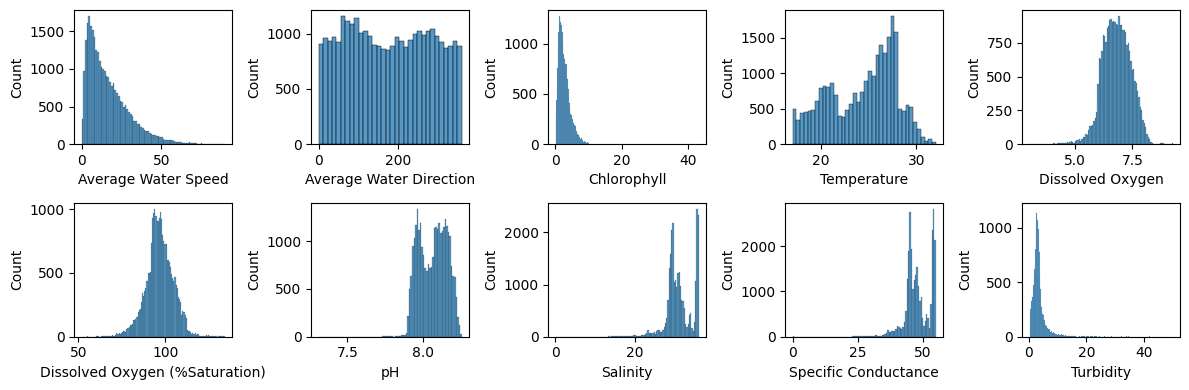

In [50]:
# Creating distribution plots
numeric_datetime_columns = df.select_dtypes(include=["number"]).columns.tolist()

# Create subplots: 4 row, 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))
r = 0
c = 0
for i in numeric_datetime_columns:
    sns.histplot(data=df, x=i, ax=axes[r, c])
    if (c + 1) % 5 == 0:
        r = r + 1
        c = 0
    else:
        c = c + 1

plt.tight_layout()
plt.show()

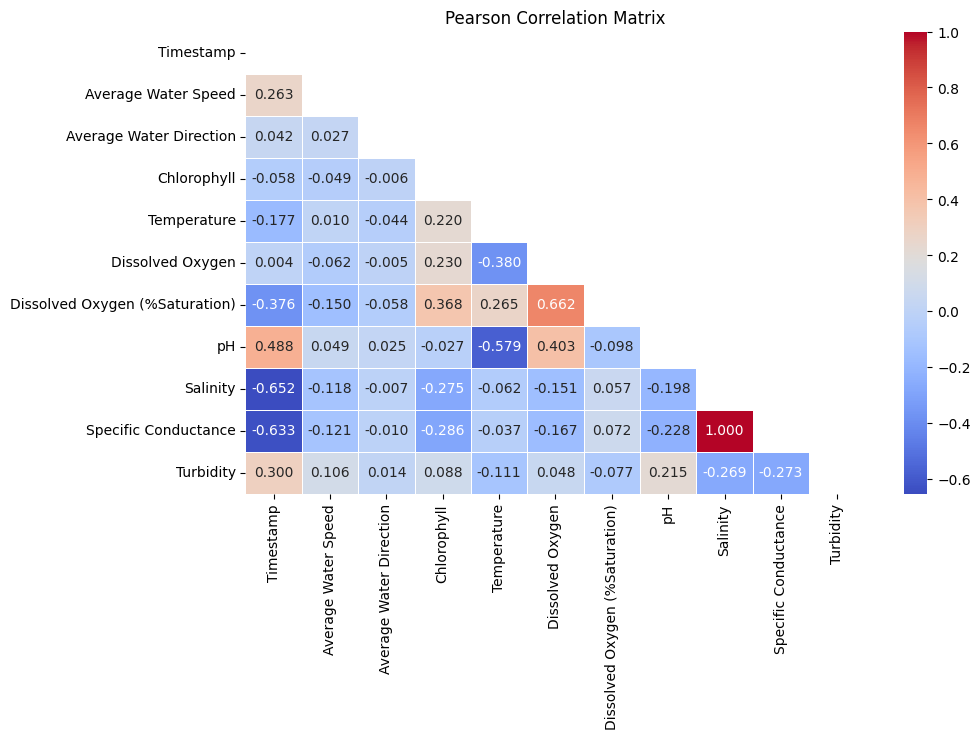

In [56]:
correlation_matrix = df.corr(method='pearson')
correlation_matrix = correlation_matrix.round(3)
masking_matrix = np.triu(correlation_matrix)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, mask=masking_matrix)
plt.title('Pearson Correlation Matrix')
plt.show()

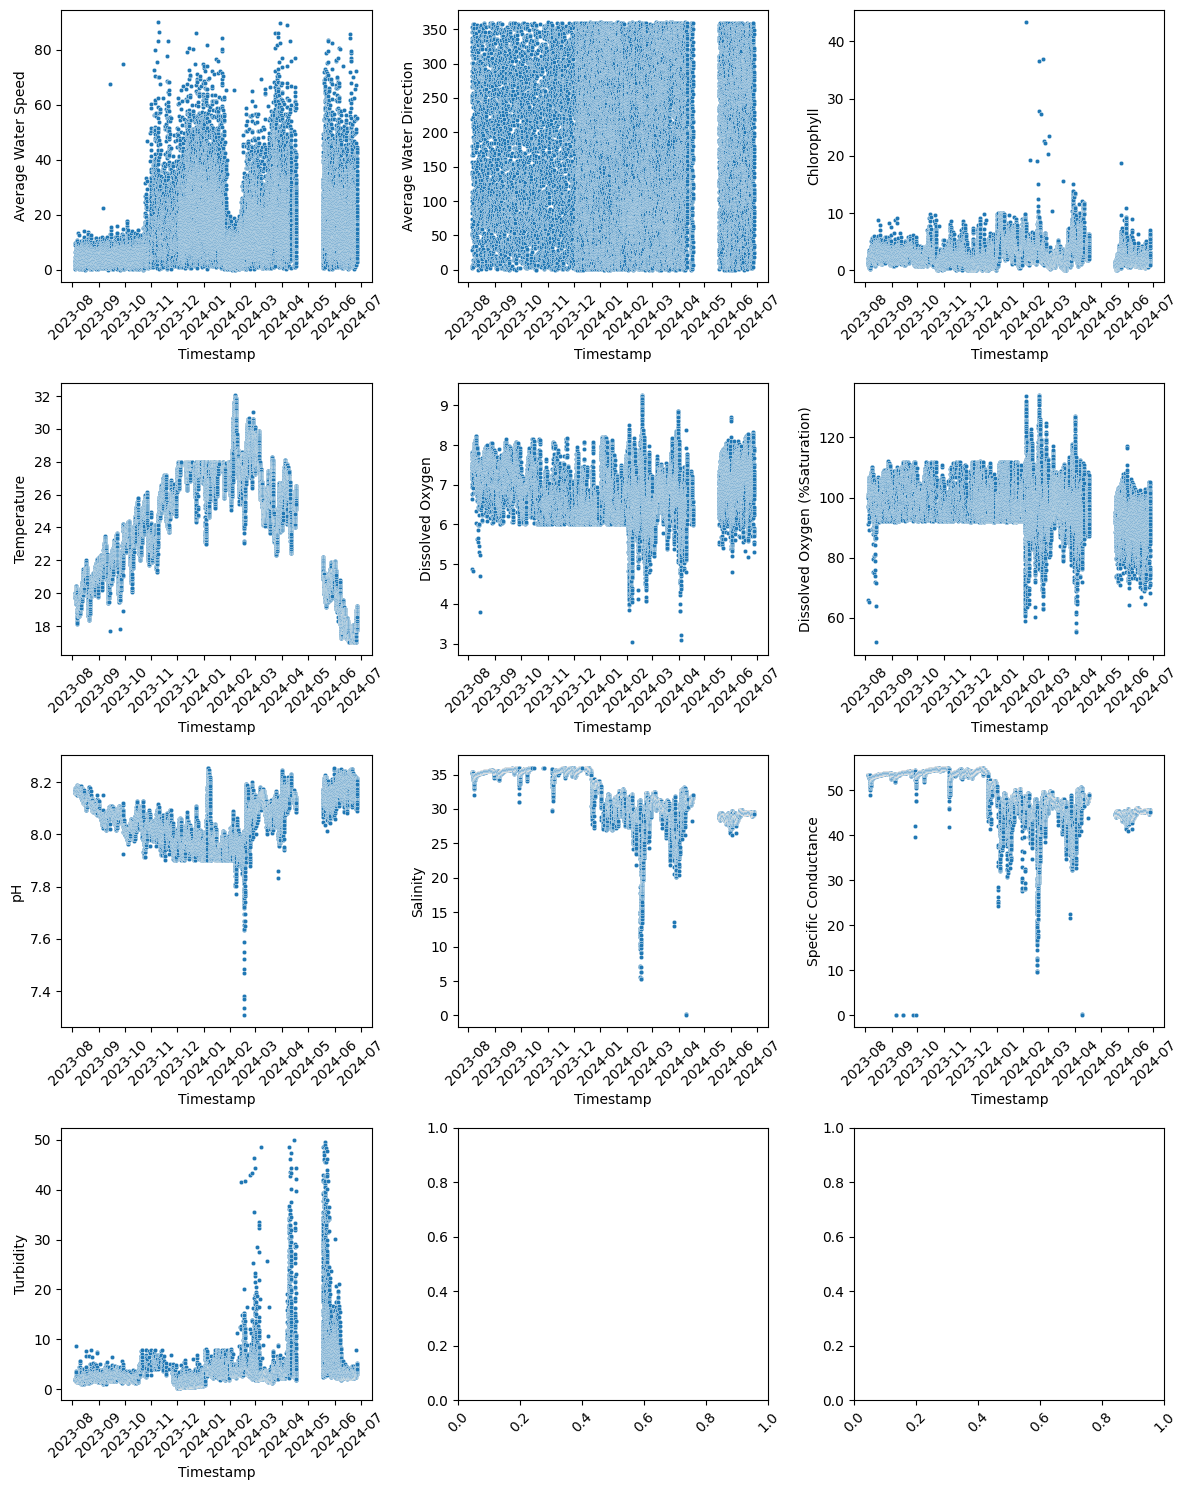

In [63]:
# Creating time series line plot
filtered_column_names.pop(0)

# Create subplots: 4 row, 5 columns
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 15))
r = 0
c = 0
for i in numeric_datetime_columns:
    sns.scatterplot(data=df, x='Timestamp', y=i, ax=axes[r, c], s=10)
    if (c + 1) % 3 == 0:
        r = r + 1
        c = 0
    else:
        c = c + 1

# Rotate date labels on all plots
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()